Что было сделано в рамках работы.

1) EDA, FE в части предобработки табличных данных

2) Построена модель на основе градиентного бустинга с помощью CatBoost

3) Построена модель на основе нейронных сетей(для таблчных данных)

4) Построена multi-input модель для анализа табличных данных и текста (используем лемматизацию)

5) Построена multi-input модель с добавлением нейронной сети обработки изображений

6) Сделан блэндинг градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [88]:
!pip install -q tensorflow==2.3

In [89]:
#аугментации изображений
!pip install albumentations -q

In [90]:
# Implement cyclical learning rate policy Algorithm 
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [91]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

import keras
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class OneCyclicP(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [92]:
#описание класса подбора гиперпараметров для CatBoost
from sortedcontainers import SortedList
import copy
import collections
import numpy as np
from itertools import product,chain
import pandas
from sklearn.model_selection import KFold
import catboost as cb

''' a class for doing grid search on a set of parameters provided in a dict. 'pdict' should be a dictionary like the following:
pdict = {'depth':[1,2], 'iterations':[250,100,500], 'thread_count':4}

when grid_search is called it will return an iterator that provides samples from the dictionary e.g.
{'depth':1, 'iterations':250, 'thread_count':4}
{'depth':2, 'iterations':250, 'thread_count':4}
{'depth':1, 'iterations':100, 'thread_count':4}
etc.
after calling an iteration of grid_search, you need to test the classifier and run 'register_result'
This will update the internal list of results, so that the next call to grid_search will use the best
parameters for all the parameters not currently being updated.

grid_search can be provided a list e.g. grid_search(['depth']) this will use the current best parameters for all
the other arguments and only search over 'depth'. You can then call e.g. grid_search(['iterations']) and it will use
the best depth found previously and cycle through all the 'iterations'. Searching incrementally can be much faster
than doing a full grid search, but may miss the global optimum. '''
class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        # if something is not passed in as a sequence, make it a sequence with 1 element
        #   don't treat strings as sequences
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        # our results are a sorted list, so the best score is always the final element
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        # do grid search on only the keys listed. If none provided, do all
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            # do any changes to the current best parameter set
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            # if our updates are the same as current best, don't bother
            if self.equaldict(dict(p),template): continue
            # take the current best and update just the ones to change
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            
    
    # save a (score,params) pair to results. Since 'results' is a sorted list,
    #   the best score is always the final element. A small amount of noise is added
    #   because sorted lists don't like it when two scores are exactly the same    
    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[-1][0]
        
    def bestparam(self):
        return self.results[-1][1]

In [93]:
!pip install --upgrade pip -q efficientnet


In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

import albumentations

from sklearn.model_selection import KFold

import catboost as cb

import pandas_profiling

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

import efficientnet.keras as efn
import tensorflow.keras.models as M
from tensorflow.keras import layers
import tensorflow.keras.layers as L
import albumentations as albumentations

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

In [95]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    df_output.drop(['description', 'sell_id'], axis = 1, inplace=True)
    
    # Нормализация данных
        
    #scaler = StandardScaler()
    #for column in numerical_features:
    #    df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    #for column in numerical_features:
    #    df_output[numerical_features] = df_output[numerical_features].apply(lambda x: np.log(x))
    
    #scaler =  StandardScaler() # MinMaxScaler() #StandardScaler() 
    #for column in numerical_features:
    #    df_output[column] = np.log(df_output[column])
    #    df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = np.log(df_output[column])
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    #создание полиноммиальных признаков 
    #for column in numerical_features:
    #   polyfeatires = PolynomialFeatures(2).fit_transform(df_output[column].values)[:,1:]
    #   df_output = pd.concat([df_output, pd.DataFrame(polyfeatires)], axis=1)
        
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    return df_output

def fe_add_taxes(data_frame, column_name):
    data_frame['taxes'] = data_frame[column_name].apply(lambda x: (x <= 100.0 and 1) or (100.0 < x <= 125.0 and 2) or (115.0 < x <= 150.0 and 3) 
                                               or (150.0 < x <= 175.0 and 4) or (175.0 < x <= 200.0 and 5) or (200.0 < x <= 225.0 and 6)
                                               or (225.0 < x <= 250.0 and 7) or (x > 250.0 and 8))
    return data_frame['taxes']



In [96]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
pip install pandas-profiling


# EDA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [ ]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.info()

In [ ]:
#посмотрим на распределение данных, корредляции и т.д.
pandas_profiling.ProfileReport(train)

### проанализируем категориальные переменные


In [ ]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='price', 
                data=train.loc[train.loc[:, column].isin(train.loc[:, column])],#hue ='health',
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#отобразим данные
for col in [
    'bodyType',
    'brand',
    'color',
    'engineDisplacement',
    'enginePower',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'Руль',
    ]:
    get_boxplot(col)

In [ ]:
def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [ ]:
for col in [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод',
    'Руль',
    ]:
    get_stat_dif(col)

In [ ]:
#data.isna().sum()

In [ ]:
train.brand

# FE и обработка данных
Что будем делать: 
1. Добавим признак налогового платежа(зависит от мощности двигателя)

In [118]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

train['engineDisplacement'] = train['engineDisplacement'].str.split().apply(lambda s: s[0]) 

train.loc[train.engineDisplacement=='undefined', 'engineDisplacement'] = '2.0' 
train.loc[train.engineDisplacement=='0.7', 'engineDisplacement'] = '1.0' 
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda s: float(s)) 

train['enginePower'] = train['enginePower'].str.split().apply(lambda s: s[0]) 
train['enginePower'] = train['enginePower'].apply(lambda s: float(s))

train.drop(['description','Руль','name', 'vehicleConfiguration', 'Владение', 'modelDate' ], axis=1, inplace=True)
 
train['productionDate']=2021-train['productionDate']

train.loc[train['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'

#mileagePerYear - сделаем новый признак - пробег в год 
train['mileagePerYear']=train['mileage']/train['productionDate']

#taxes - сделаем новый признак - налоговая ставка 
train['taxes'] = fe_add_taxes(train, 'enginePower')


test['engineDisplacement'] = test['engineDisplacement'].str.split().apply(lambda s: s[0]) 
test.loc[test.engineDisplacement=='undefined', 'engineDisplacement'] = '2.0' 
test.loc[test.engineDisplacement=='0.7', 'engineDisplacement'] = '1.0' 
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda s: float(s)) 

test['enginePower'] = test['enginePower'].str.split().apply(lambda s: s[0]) 
test['enginePower'] = test['enginePower'].apply(lambda s: float(s))


test.drop(['Руль','name', 'vehicleConfiguration', 'Владение', 'modelDate' ], axis=1, inplace=True)

 
test['productionDate']=2021-test['productionDate']

test.loc[train['Владельцы'].isna()==True, 'Владельцы'] = '3 или более'


#mileagePerYear - сделаем новый признак - пробег в год 
test['mileagePerYear']=test['mileage']/test['productionDate']
#taxes - сделаем новый признак - налоговая ставка
test['taxes'] = fe_add_taxes(test, 'enginePower')





In [119]:
#сгруппируем признаки для дальнейшей обработки
categorical_features = ['taxes','color','bodyType', 'brand', 'fuelType', 'model_info', 'vehicleTransmission', 'ПТС', 'Привод','Владельцы' ]

categorical_features_for_dummy = ['taxes','color','bodyType', 'brand', 'fuelType', 'model_info', 'vehicleTransmission', 'ПТС', 'Привод','Владельцы' ]

numerical_features = ['mileage', 'productionDate','engineDisplacement', 'enginePower','mileagePerYear']

categorical_features_PN = ['productionDate', 'mileagePerYear','mileage']
categorical_features_PN1 = ['engineDisplacement', 'enginePower']





                       




In [120]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)


(6682, 19) (1671, 20) (8353, 20)


In [121]:
#создадим полиномиальные признаки и обрабоаем данные
#polyfeatires = PolynomialFeatures(2).fit_transform(data[categorical_features_PN].values)[:,1:]
#data = pd.concat([data, pd.DataFrame(polyfeatires)], axis=1)

df_preproc = preproc_data(data)
df_preproc.head(20)

,engineDisplacement,enginePower,mileage,numberOfDoors,productionDate,mileagePerYear,sample,price,taxes_0,taxes_1,...,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Владельцы_0,Владельцы_1,Владельцы_2
0,0.582179,0.481798,0.924011,5,0.928385,0.847272,0,0.0,0,0,...,0,0,0,1,1,0,0,0,0,1
1,0.582179,0.639649,0.696015,2,0.567601,0.699235,0,0.0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,0.485563,0.477709,0.870279,2,0.700125,0.854876,0,0.0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,0.367314,0.266462,0.861220,4,0.720353,0.838740,0,0.0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0.367314,0.416162,0.730035,4,0.189200,0.849553,0,0.0,0,0,...,0,0,0,1,0,0,1,1,0,0
5,0.582179,0.676694,0.809555,4,0.378401,0.882386,0,0.0,0,0,...,0,0,0,1,0,0,1,1,0,0
6,0.582179,0.529985,0.854309,5,0.567601,0.876325,0,0.0,0,0,...,0,0,0,1,0,0,1,0,0,1
7,0.663867,0.643920,0.834054,2,0.700125,0.814349,0,0.0,0,0,...,0,0,1,0,1,0,0,0,0,1
8,0.311481,0.366365,0.832088,5,0.531153,0.862278,0,0.0,0,0,...,0,0,0,1,0,1,0,0,1,0
9,0.311481,0.339223,0.883235,4,0.700125,0.869370,0,0.0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [ ]:
df_preproc.info()

In [ ]:
train.engineDisplacement

# Model 1: Градиентный бустинг - CatBoostRegressor

In [122]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [123]:
#model = CatBoostRegressor(bestparams)
model = CatBoostRegressor(iterations = 5000,
                          #depth=16,
                          #learning_rate = 0.08,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,                           
                          #task_type='GPU',
                         )


model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9864127	test: 1.0101103	best: 1.0101103 (0)	total: 3.87ms	remaining: 19.4s
100:	learn: 0.3001479	test: 0.2998293	best: 0.2998293 (100)	total: 317ms	remaining: 15.4s
200:	learn: 0.2371346	test: 0.2346874	best: 0.2346874 (200)	total: 637ms	remaining: 15.2s
300:	learn: 0.2010695	test: 0.2000020	best: 0.2000020 (300)	total: 972ms	remaining: 15.2s
400:	learn: 0.1845332	test: 0.1853847	best: 0.1853847 (400)	total: 1.49s	remaining: 17.1s
500:	learn: 0.1770607	test: 0.1787286	best: 0.1787286 (500)	total: 1.86s	remaining: 16.7s
600:	learn: 0.1693340	test: 0.1713582	best: 0.1713582 (600)	total: 2.17s	remaining: 15.9s
700:	learn: 0.1620095	test: 0.1654311	best: 0.1654182 (699)	total: 2.47s	remaining: 15.1s
800:	learn: 0.1554797	test: 0.1605618	best: 0.1605475 (794)	total: 2.79s	remaining: 14.7s
900:	learn: 0.1498052	test: 0.1562848	best: 0.1562848 (900)	total: 3.11s	remaining: 14.1s
1000:	learn: 0.1461230	test: 0.1536996	best: 0.1536634 (995)	total: 3.42s

KeyboardInterrupt: 

In [ ]:
#подбор гиперпараметров для CatBoost
params = {'depth':[1,2,3,4,5,6,7,8,9,10],
          'iterations':[100,500,1000,5000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4}

def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.loc[train_index]
        test_labels = train_label.loc[test_index]

        clf = cb.CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,s,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams = catboost_param_tune(params,df_preproc,df_preproc['price'],categorical_features_GS)


In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

### Submission

In [141]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/preprocessing/normalization.py:159 call
        return (inputs - mean) / math_ops.sqrt(variance)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 188 and 3 for '{{node functional_11/normalization_8/sub}} = Sub[T=DT_FLOAT](functional_11/rescaling_8/add, functional_11/normalization_8/Reshape)' with input shapes: [?,188], [1,1,1,3].


# Model 2: Нейронная сеть для табличных данных

Построим обычную сеть:

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
max_lr = 0.0001
base_lr = max_lr/10

max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35


optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

clr = CyclicLR(base_lr=0.00001, max_lr=0.0009,step_size=2000., mode='triangular')

#clr =  OneCyclicP(base_lr=base_lr,max_lr=max_lr,
#    step_size=step_size,max_m=0.98,
#    base_m=base_m,cyclical_momentum=cyclical_momentum)

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop,clr]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [ ]:
data.description

In [ ]:
data.description.isna().sum()


# Model 4: NLP + Multiple Inputs


### подготовим текст для NLP

In [ ]:
# загрузка стоп слов

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("russian")
stopwords

In [ ]:
# Дополним список СТОП слов (можно добавить любые слова):

stopwords_add = list(set(['что', '000', '00', '3', '2', 'й','r19', 'это', '[smart]', 'также', '2017', 'вот', 'быть', 'как', 'в', '•', 'и', 'с', 'на', 'не', 'по', 'все', 'для', 'от', 'в', 'до', 'при', 'у','пр','на','для','б','———————————————————————————', 'о','тот', 'этот',
 '2', 'без', 'за','то', 'есть', '1', 'года', 'только', '6', 'км', 'лет', '3', 'а', 'мы', '9' , 'вас', '5', '–', 'м', '∙', 'я', 'ваш', '4', 'вы', '7', 'm', 'к', '00', 'год', '10', '8', '—',  'ii', 'gt', '❤️', 'др' , 'м', '5', '6', '9', '2', 'hegcedh',          
 'л', 'всех', 'in', 'о', 'т', 'же', 'ни',  'под', 'можете', 'была', 'д', 'тыс', '0', 's', 'час', 'вся', 'всё', 'наш', 'г', '30', '11', 'если', 'возможна', 'это', 'себя', '☑️', 'нам', '50',  'ин', 'c', 'во', '✔',
 'х', '➥', '40', 'ряд', 'этого', '2018', '13', '●', 'эл', 'ти', '25', 'могу', '01', 'fi', '·', '2014', '✅', 'ещё','й', 'б', 'позвоните', '72', 'гк', 'сел', '03811', 'uy07066', 'в','v', '3', 'и','а', 'я','вы', 'нет', 'тем',
 'поехал', 'ооо', '☛', 'раз', 'i','bmw', 'км', 'с', 'amg' '60', '«гарантия', 'р', 'кто', 'тд', '2013', 'мне', 'там', 'информации', '2016', 'лицо', 'еще',  '2012', 'оф', 'л'
 ]))
stopwords.extend (stopwords_add)

In [ ]:
# Преобразуем все слова к маленьким буквам

data['description'] = data['description'].apply(lambda s: s.lower())

In [ ]:
def filter_str(st):
# Фильтруем стоп-слова в Desrciption:

    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s not in stopwords, split_str)))
    return filtered_str

data['description_filtered'] = data['description'].apply(filter_str)

In [ ]:
#функция очистки текста
def preprocess_text(sen):
    # Removing html tags
    #sentence = remove_tags(sen)
    
    sentence = sen
    # Remove punctuations and numbers
    #sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ',  sentence)

    return sentence

In [ ]:
data['description'] = data['description_filtered'].apply(preprocess_text)

In [ ]:
# импортируем библиотеку для лемматизации на РУССКОМ
!pip install pymorphy2
# и словарь подгружаем РУССКОМ
!pip install -U pymorphy2-dicts-ru

In [ ]:
morph = pymorphy2.MorphAnalyzer()

def filter_str(str):
  # лемматизации текста

    split_str = str.split()
    filtered_str = ' '.join((map(lambda s: morph.parse(s)[0].normal_form , split_str)))
    return filtered_str

data['description'] = data['description'].apply(filter_str)

In [ ]:
# Заменим слова и выражения на коды

data['description'] = data['description'].apply(lambda s: s.replace('машина', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('а/м', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачилу', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачка', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('автомобиль', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('состоянии', 'состояние'))
data['description'] = data['description'].apply(lambda s: s.replace('официальный дилера', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('оф. дилер', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('гарантия производитель', 'код2'))
data['description'] = data['description'].apply(lambda s: s.replace('сервисный книжка', 'код3'))
data['description'] = data['description'].apply(lambda s: s.replace('гаражный хранение', 'код4'))
data['description'] = data['description'].apply(lambda s: s.replace('хороший состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('отличный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('идеальный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('птс оригинал', 'код6'))
data['description'] = data['description'].apply(lambda s: s.replace('добрый день', 'код7'))
data['description'] = data['description'].apply(lambda s: s.replace('рулевой колонка управление', 'код8'))
data['description'] = data['description'].apply(lambda s: s.replace('электрорегулировка сидение пассажир', 'код9'))
data['description'] = data['description'].apply(lambda s: s.replace('ваш удобства', 'код10'))
data['description'] = data['description'].apply(lambda s: s.replace('центральный замок', 'код11'))
data['description'] = data['description'].apply(lambda s: s.replace('доводчик дверей', 'код12'))
data['description'] = data['description'].apply(lambda s: s.replace('Климат-контроль', 'код13'))
data['description'] = data['description'].apply(lambda s: s.replace('вентиляция задний сидение', 'код14'))
data['description'] = data['description'].apply(lambda s: s.replace('система контроль слепой зона', 'код15'))
data['description'] = data['description'].apply(lambda s: s.replace('подушка безопасность', 'код16'))
data['description'] = data['description'].apply(lambda s: s.replace('широкий ассортимент', 'код17'))
data['description'] = data['description'].apply(lambda s: s.replace('гарантия юридический чистота', 'код18'))

### TOKENIZER

In [129]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [130]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)


# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
tokenize.word_index

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 4: Добавляем картинки

### Data

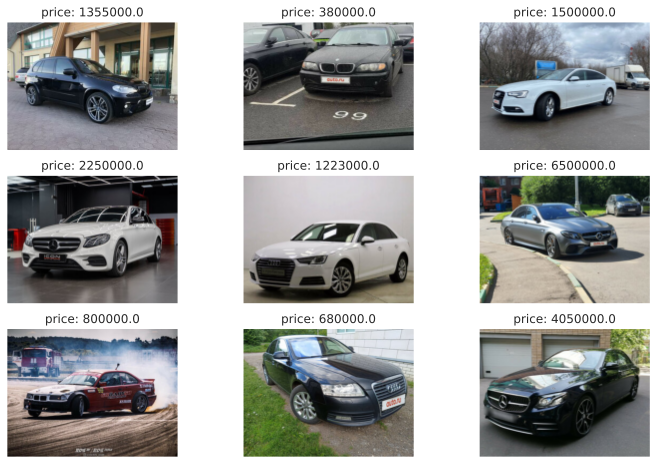

In [124]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [125]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [126]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)



In [127]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [131]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [132]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [133]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

### Finetuning 

In [ ]:
efficientnet_model.summary()
print(len(efficientnet_model.layers))

In [134]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [135]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

### learn with finetuning

In [136]:
#frozen nlp layer
nlp_model.trainable = False
tabular_model.trainable = False

combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)


model = M.Sequential() 
model.add(tf.keras.applications.efficientnet.EfficientNetB7(include_top = False, weights = "imagenet",input_shape = (size[1], size[0], 3)))
model.add(L.GlobalAveragePooling2D())
model.add(L.BatchNormalization())
model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)


model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 240, 320, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 240, 320, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization_8[0][0]            
______________________________________________________________________________________

In [137]:
max_lr = 0.0001
base_lr = max_lr/10

max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35


optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

clr = CyclicLR(base_lr=0.0001, max_lr=0.009,step_size=4000., mode='triangular')

#clr =  OneCyclicP(base_lr=base_lr,max_lr=max_lr,
#    step_size=step_size,max_m=0.98,
#    base_m=base_m,cyclical_momentum=cyclical_momentum)

In [138]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop,clr]

In [139]:
history = model.fit(train_dataset.batch(30),
                    epochs=80,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/80
190/190 [==============================] - 119s 624ms/step - loss: 99.9596 - MAPE: 99.9596 - val_loss: 99.9898 - val_MAPE: 99.9898
Epoch 2/80
190/190 [==============================] - 113s 596ms/step - loss: 99.3141 - MAPE: 99.3141 - val_loss: 99.9660 - val_MAPE: 99.9660
Epoch 3/80
190/190 [==============================] - 112s 592ms/step - loss: 94.4581 - MAPE: 94.4581 - val_loss: 154.1761 - val_MAPE: 154.1761
Epoch 4/80
190/190 [==============================] - 114s 601ms/step - loss: 79.3127 - MAPE: 79.3127 - val_loss: 214.4971 - val_MAPE: 214.4971
Epoch 5/80
190/190 [==============================] - 113s 592ms/step - loss: 61.2457 - MAPE: 61.2457 - val_loss: 191.6650 - val_MAPE: 191.6650
Epoch 6/80
190/190 [==============================] - 115s 603ms/step - loss: 50.3824 - MAPE: 50.3824 - val_loss: 50.0555 - val_MAPE: 50.0555
Epoch 7/80
190/190 [==============================] - 113s 593ms/step - loss: 49.7505 - MAPE: 49.7505 - val_loss: 50.4315 - val_MAPE: 50.4315


In [142]:
nlp_model.trainable = False
tabular_model.trainable = True

combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = M.Sequential() 
model.add(tf.keras.applications.efficientnet.EfficientNetB7(include_top = False, weights = "imagenet",input_shape = (size[1], size[0], 3)))
model.add(L.GlobalAveragePooling2D())
model.add(L.BatchNormalization())
model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 240, 320, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 240, 320, 3)  7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization_8[0][0]            
______________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [143]:
max_lr = 0.0001
base_lr = max_lr/10

max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35


optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

clr = CyclicLR(base_lr=0.00001, max_lr=0.0001,step_size=3000., mode='triangular')

#clr =  OneCyclicP(base_lr=base_lr,max_lr=max_lr,
#    step_size=step_size,max_m=0.98,
#    base_m=base_m,cyclical_momentum=cyclical_momentum)

In [144]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop,clr]

In [145]:
history = model.fit(train_dataset.batch(30),
                    epochs=60,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/60
190/190 [==============================] - 117s 616ms/step - loss: 99.9977 - MAPE: 99.9977 - val_loss: 99.9951 - val_MAPE: 99.9951
Epoch 2/60
190/190 [==============================] - 116s 610ms/step - loss: 99.9922 - MAPE: 99.9922 - val_loss: 99.9865 - val_MAPE: 99.9865
Epoch 3/60
190/190 [==============================] - 113s 595ms/step - loss: 99.9804 - MAPE: 99.9804 - val_loss: 99.9654 - val_MAPE: 99.9654
Epoch 4/60
190/190 [==============================] - 113s 596ms/step - loss: 99.9466 - MAPE: 99.9466 - val_loss: 99.9019 - val_MAPE: 99.9019
Epoch 5/60
190/190 [==============================] - 114s 601ms/step - loss: 99.8299 - MAPE: 99.8299 - val_loss: 99.6984 - val_MAPE: 99.6984
Epoch 6/60
190/190 [==============================] - 113s 597ms/step - loss: 99.4676 - MAPE: 99.4676 - val_loss: 99.1093 - val_MAPE: 99.1093
Epoch 7/60
190/190 [==============================] - 114s 598ms/step - loss: 98.5094 - MAPE: 98.5094 - val_loss: 97.6292 - val_MAPE: 97.6292
Epoch 

190/190 [==============================] - 114s 599ms/step - loss: 35.9102 - MAPE: 35.9102 - val_loss: 34.1135 - val_MAPE: 34.1135
Epoch 59/60
190/190 [==============================] - 115s 604ms/step - loss: 35.5776 - MAPE: 35.5776 - val_loss: 34.0260 - val_MAPE: 34.0260
Epoch 60/60
190/190 [==============================] - 114s 600ms/step - loss: 35.5350 - MAPE: 35.5350 - val_loss: 33.9045 - val_MAPE: 33.9045


In [ ]:
nlp_model.trainable = True
tabular_model.trainable = True

combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = M.Sequential() 
model.add(tf.keras.applications.efficientnet.EfficientNetB7(include_top = False, weights = "imagenet",input_shape = (size[1], size[0], 3)))
model.add(L.GlobalAveragePooling2D())
model.add(L.BatchNormalization())
model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
max_lr = 0.0001
base_lr = max_lr/10

max_m = 0.98
base_m = 0.85

cyclical_momentum = True
augment = True
cycles = 2.35


optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

clr = CyclicLR(base_lr=0.00001, max_lr=0.0001,step_size=4000., mode='triangular')

#clr =  OneCyclicP(base_lr=base_lr,max_lr=max_lr,
#    step_size=step_size,max_m=0.98,
#    base_m=base_m,cyclical_momentum=cyclical_momentum)

In [148]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop, clr]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=70,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/70
190/190 [==============================] - 140s 737ms/step - loss: 95.9471 - MAPE: 95.9471 - val_loss: 94.8391 - val_MAPE: 94.8391
Epoch 2/70
190/190 [==============================] - 143s 754ms/step - loss: 93.3150 - MAPE: 93.3150 - val_loss: 91.5559 - val_MAPE: 91.5559
Epoch 3/70
190/190 [==============================] - 142s 747ms/step - loss: 89.2188 - MAPE: 89.2188 - val_loss: 86.4492 - val_MAPE: 86.4492
Epoch 4/70
190/190 [==============================] - 141s 741ms/step - loss: 82.9208 - MAPE: 82.9208 - val_loss: 78.7182 - val_MAPE: 78.7182
Epoch 5/70
190/190 [==============================] - 141s 742ms/step - loss: 73.4434 - MAPE: 73.4434 - val_loss: 67.2150 - val_MAPE: 67.2150
Epoch 6/70
190/190 [==============================] - 142s 749ms/step - loss: 61.2080 - MAPE: 61.2080 - val_loss: 54.7249 - val_MAPE: 54.7249
Epoch 7/70
190/190 [==============================] - 143s 753ms/step - loss: 51.1036 - MAPE: 51.1036 - val_loss: 47.2986 - val_MAPE: 47.2986
Epoch 

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0])/2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
sub_predict_bredict = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_bredict[:,0]
sample_submission.to_csv('nnf_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")